In [1]:
import tensorflow as tf
from tensorflow.keras import models , layers
import matplotlib.pyplot as plt
%matplotlib inline

## Download Images into tf.images.dataset

In [2]:
Image_size = 256
Batch_size = 32
Channels = 3

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    'Potato_Data',
    shuffle=True,
    image_size= (Image_size,Image_size),
    batch_size= Batch_size
)

Found 2152 files belonging to 3 classes.


In [4]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
len(dataset)

68

## Data visualization

In [6]:
for image_batch , label_batch in dataset.take(1) :  # It gives us one batch which equals to 32 images 
    print(image_batch[0].numpy()) # because it is a tensor 


[[[121. 106. 111.]
  [130. 115. 120.]
  [126. 111. 116.]
  ...
  [181. 169. 173.]
  [177. 165. 169.]
  [173. 161. 165.]]

 [[121. 106. 111.]
  [122. 107. 112.]
  [122. 107. 112.]
  ...
  [175. 163. 167.]
  [174. 162. 166.]
  [172. 160. 164.]]

 [[157. 142. 147.]
  [150. 135. 140.]
  [146. 131. 136.]
  ...
  [170. 158. 162.]
  [171. 159. 163.]
  [170. 158. 162.]]

 ...

 [[ 99.  84.  91.]
  [120. 105. 112.]
  [104.  89.  96.]
  ...
  [167. 157. 165.]
  [169. 159. 167.]
  [172. 162. 170.]]

 [[105.  90.  97.]
  [137. 122. 129.]
  [ 89.  74.  81.]
  ...
  [168. 158. 166.]
  [169. 159. 167.]
  [171. 161. 169.]]

 [[114.  99. 106.]
  [117. 102. 109.]
  [ 81.  66.  73.]
  ...
  [168. 158. 166.]
  [168. 158. 166.]
  [170. 160. 168.]]]


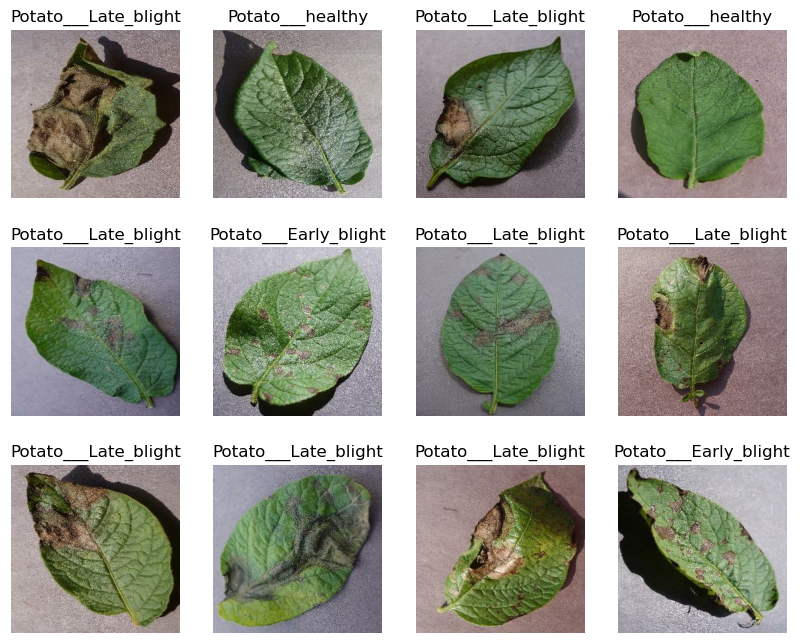

In [7]:
plt.figure(figsize=(10,8))
for image_batch , label_batch in dataset.take (1) :
    for i in range(12) :
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.axis('off')
        plt.title(class_names[label_batch[i]])

## Train Test Split

In [8]:
len(dataset)

68

In [9]:
def get_dataset_partitions_tf(ds, ds_size, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    if shuffle:
        # Specify seed to always have the same split distribution between runs
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [10]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset,len(dataset))

In [11]:
print('Length of Train ds :',len(train_ds))
print('Length of Validation ds :',len(val_ds))
print('Length of Test ds :',len(test_ds))

Length of Train ds : 54
Length of Validation ds : 6
Length of Test ds : 8


In [12]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [13]:
resizing_rescaling = tf.keras.Sequential([
    
    layers.experimental.preprocessing.Resizing(Image_size,Image_size),
    layers.experimental.preprocessing.Rescaling(1.0/255)
    
])

In [14]:
data_augmentation = tf.keras.Sequential([
    
    layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    layers.experimental.preprocessing.RandomRotation(0.2)
    
])

# Model building

In [15]:
input_shape = (Batch_size,Image_size,Image_size,Channels)
n_classes = 3 
model = models.Sequential([
    
    resizing_rescaling,
    data_augmentation,
    layers.Conv2D(32,kernel_size=(3,3),activation='relu',input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes,activation='softmax')
])

model.build(input_shape=input_shape)

In [16]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

In [17]:
model.compile( 
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics='accuracy'
)

In [18]:
history = model.fit(
    train_ds,
    epochs=20,
    batch_size=Batch_size,
    verbose=1,
    validation_data=val_ds,
    
)

Epoch 1/20
54/54 [==============================] - 94s 2s/step - loss: 0.9034 - accuracy: 0.4873 - val_loss: 0.8360 - val_accuracy: 0.5260
Epoch 2/20
54/54 [==============================] - 83s 2s/step - loss: 0.7269 - accuracy: 0.6672 - val_loss: 0.5285 - val_accuracy: 0.7865
Epoch 3/20
54/54 [==============================] - 82s 2s/step - loss: 0.5277 - accuracy: 0.7726 - val_loss: 0.4404 - val_accuracy: 0.8073
Epoch 4/20
54/54 [==============================] - 81s 2s/step - loss: 0.3489 - accuracy: 0.8559 - val_loss: 0.4306 - val_accuracy: 0.7865
Epoch 5/20
54/54 [==============================] - 81s 2s/step - loss: 0.3400 - accuracy: 0.8588 - val_loss: 0.3860 - val_accuracy: 0.8281
Epoch 6/20
54/54 [==============================] - 82s 2s/step - loss: 0.2103 - accuracy: 0.9201 - val_loss: 0.5457 - val_accuracy: 0.8542
Epoch 7/20
54/54 [==============================] - 82s 2s/step - loss: 0.2253 - accuracy: 0.9132 - val_loss: 0.1893 - val_accuracy: 0.9323
Epoch 8/20
54/54 [==

In [19]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 4s 365ms/step - loss: 0.2143 - accuracy: 0.9531


In [20]:
history.params

{'verbose': 1, 'epochs': 20, 'steps': 54}

In [21]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [22]:
loss = history.history['loss']
acc = history.history['accuracy']
val_loss = history.history['val_loss']
val_accuracy = history.history['val_accuracy']

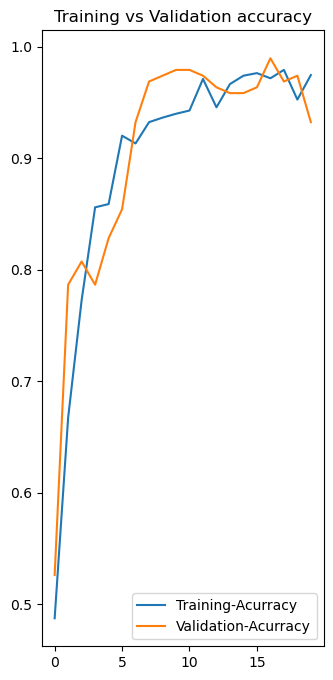

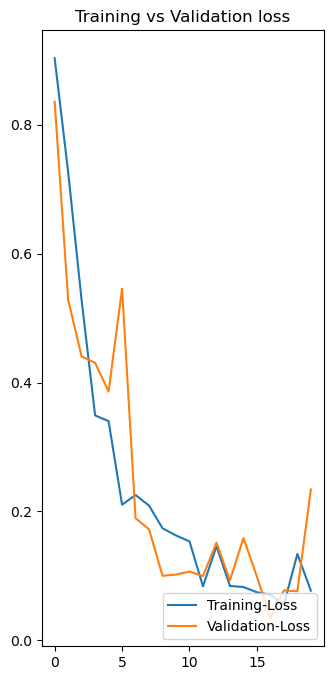

In [23]:
plt.figure(figsize=(8,8))
plt.subplot(1, 2, 1)
plt.plot(range(20),acc,label='Training-Acurracy')
plt.plot(range(20),val_accuracy,label='Validation-Acurracy')
plt.legend(loc='lower right')
plt.title('Training vs Validation accuracy')

plt.figure(figsize=(8,8))
plt.subplot(1, 2, 2)
plt.plot(range(20),loss,label='Training-Loss')
plt.plot(range(20),val_loss,label='Validation-Loss')
plt.legend(loc='lower right')
plt.title('Training vs Validation loss')

plt.show()

first image to predict
actual label : Potato___healthy
1/1 [==============================] - 0s 247ms/step
predicted class : Potato___healthy


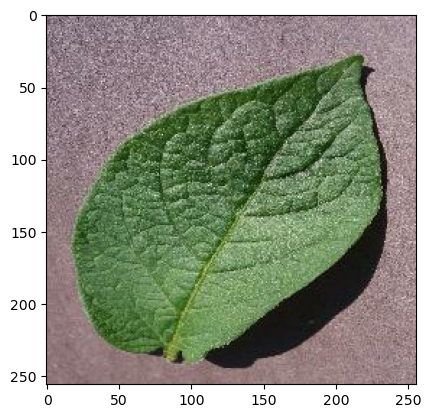

In [35]:
import numpy as np
for image_batch,label_batch in test_ds.take(1) :
    first_image = image_batch[0].numpy().astype('uint8')
    first_label = label_batch[0]
    
    print('first image to predict')
    plt.imshow(first_image)
    print('actual label :',class_names[first_label])
    
    batch_pred = model.predict(image_batch)
    print('predicted class :',class_names[np.argmax(batch_pred[0])])

In [36]:
def predict(model,img) :
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array,0) 
    
    predictions = model.predict(img_array)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100*(np.max(predictions[0])),2)
    
    return predicted_class,confidence

1/1 [==============================] - 0s 27ms/step


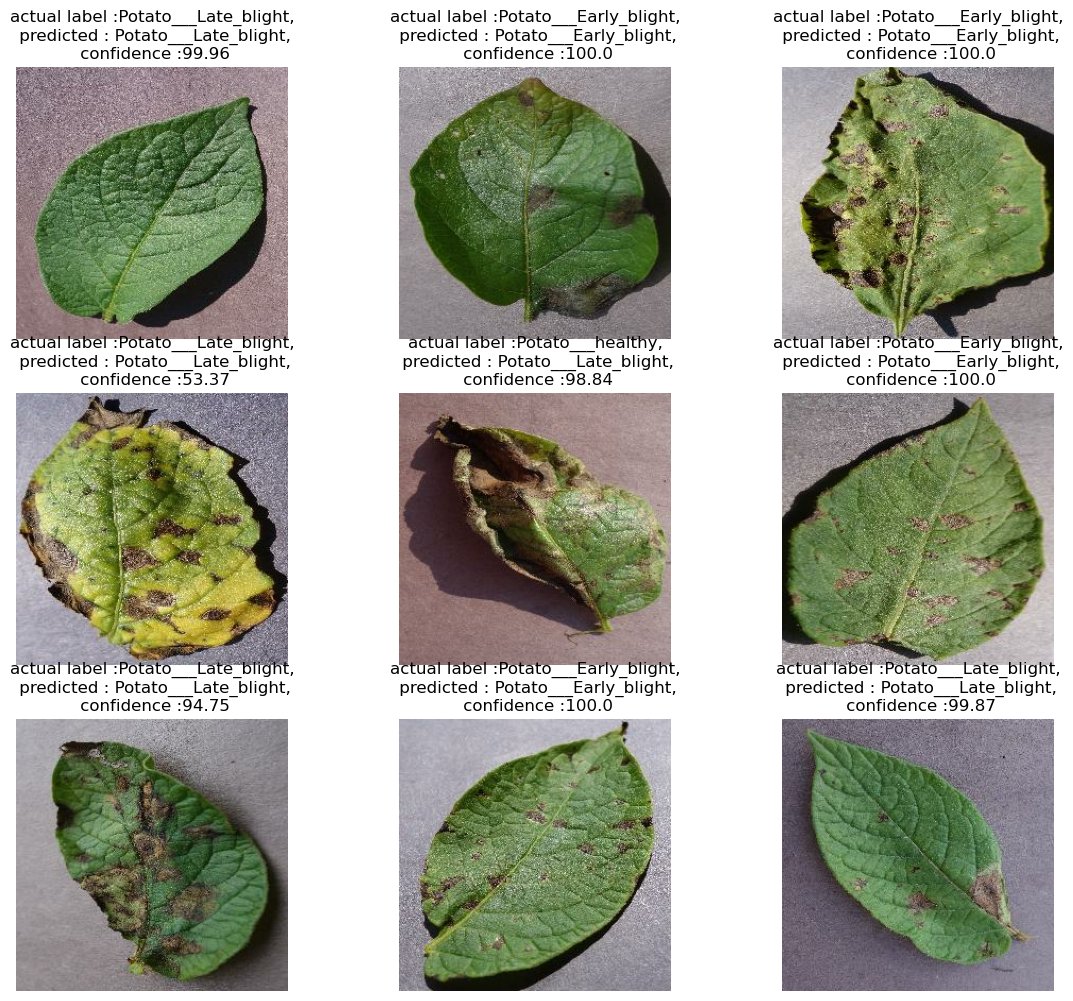

In [51]:
plt.figure(figsize=(14,12))
for images,labels in test_ds.take(1) :
    for i in range(9) :
        plt.subplot(3,3,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        predict_class , confidenece = predict(model,images[i].numpy())
        actual_class = class_names[labels[i]]
        plt.axis('off')
        plt.title(f'actual label :{actual_class},\n predicted : {predict_class},\n confidence :{confidenece}')

In [61]:
model_version = 1 
model.save('C:/Users/user/Documents/GitHub/Potato-disease-clssifcation-using-CNN/models')

INFO:tensorflow:Assets written to: C:/Users/user/Documents/GitHub/Potato-disease-clssifcation-using-CNN/models\assets


INFO:tensorflow:Assets written to: C:/Users/user/Documents/GitHub/Potato-disease-clssifcation-using-CNN/models\assets
